In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [4]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())
df_bag_of_frames.shape

(1000, 2244)

# 2. SimHash

In [5]:
%%time
embeddings = simhash(df_bag_of_frames)
embeddings

CPU times: user 2.98 s, sys: 0 ns, total: 2.98 s
Wall time: 3 s


array([[0, 0, 1, ..., 1, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 1, 1]])

# 3. Locality Sensitive Hashing

In [6]:
size_vector = 8
max_permutation = int(embeddings.shape[1] / size_vector)

l = list(np.arange(max_permutation))
combinations = list(itertools.combinations(l, 4))
hash_tables = create_hash_tables_simhash(combinations, embeddings, size_vector)

In [7]:
index = 22
set_near_duplicates = near_duplicates_simhash(index, combinations, embeddings, size_vector, hash_tables)
set_near_duplicates

{22, 87, 437}

In [8]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [9]:
near_duplicates_sim = df_measures['Cosine'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

21811    0.960000
22161    0.862911
Name: Cosine, dtype: float64

In [10]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Cosine', n_stacks, n_duplicate_pairs)
set_real_nns

{87, 188}

In [11]:
real_nns_sim[:n_duplicate_pairs]

21912    0.980581
21811    0.960000
dtype: float64

# 4. Metrics (SimHash)

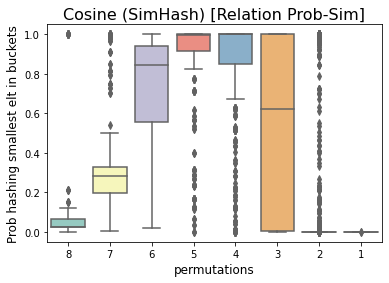

In [95]:
df_probLSH = mean_prob_hashing_smallest_elt_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine', trace = False)

f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("permutations", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Cosine (SimHash) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/SimHash/Cosine-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

## 4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [49]:
'All params'
k_first_positions = 1
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine', k_first_positions)

0.614

In [ ]:
'Best param'
k_first_positions = 1
recal_rate_one_param_simhash (n_stacks, 4, embeddings, size_vector, df_measures, 'Cosine', k_first_positions)

-----------------------------------------------------------------

In [50]:
'All params'
k_first_positions = 3
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine', k_first_positions)

0.619000000000001

In [ ]:
'Best param'
k_first_positions = 3
recal_rate_one_param_simhash (n_stacks, 4, embeddings, size_vector, df_measures, 'Cosine', k_first_positions)

-----------------------------------------------------------------

In [51]:
'All params'
k_first_positions = 5
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine', k_first_positions)

0.6188000000000025

In [ ]:
'Best param'
k_first_positions = 5
recal_rate_one_param_simhash (n_stacks, 4, embeddings, size_vector, df_measures, 'Cosine', k_first_positions)

## 4.2. Generalized MRR

In [96]:
df_knns = mean_generalized_mrr_simhash (n_stacks, max_permutation, embeddings, size_vector, df_measures, 'Cosine', trace = False)
df_knns.mean(skipna = True, axis = 0).mean()

0.8042703505132129

In [ ]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_knns, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Generalized MRR", fontsize = 12)
plt.title('Cosine (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/Generalized-MRR', bbox_inches='tight')
plt.show()

## 4.3. Recall w.r.t. LSH

In [12]:
df_recall = recall_all_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures , 'Cosine', trace = False)
df_recall.mean(skipna = True, axis = 0)

8    1.000000
7    0.092815
6    0.224581
5    0.335151
4    0.461984
3    0.602097
2    0.729474
1    0.850389
dtype: float64

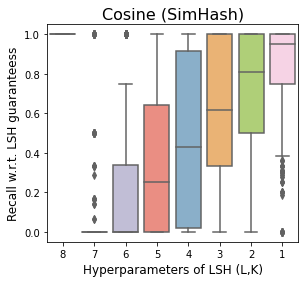

In [13]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Recall w.r.t. LSH guaranteess", fontsize = 12)
plt.title('Cosine (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/Recall-LSH', bbox_inches='tight')
plt.show()

## 4.4. Precision w.r.t. LSH

In [14]:
df_precision = precision_all_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures , 'Cosine', trace = False)
df_precision.mean(skipna = True, axis = 0)

8    0.146789
7    0.211925
6    0.846285
5    0.906536
4    0.924915
3    0.747160
2    0.483428
1    0.176072
dtype: float64

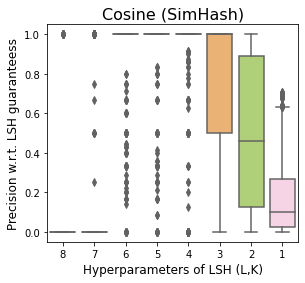

In [15]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Precision w.r.t. LSH guaranteess", fontsize = 12)
plt.title('Cosine (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/Precision-LSH', bbox_inches='tight')
plt.show()

## 4.5. Fscore w.r.t. LSH

In [16]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

8    0.146789
7    0.071233
6    0.252471
5    0.381957
4    0.517292
3    0.584588
2    0.495670
1    0.250732
dtype: float64

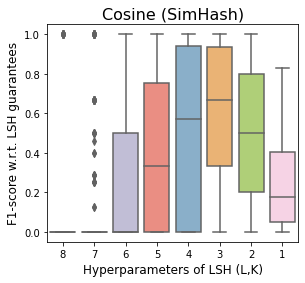

In [17]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 12)
plt.title('Cosine (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/fscore-LSH', bbox_inches='tight')
plt.show()